## Project Title: Automated Detection of Diabetic Retinopathy Using Convolutional Neural Networks

### Step 1: Import necessary python Libraries 

In [8]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
import random
from PIL import Image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

### step 2: Data Augmentation

In [74]:
# open each folder and perform data augmentation
# 7220 images for each class

# project to distinguish stages in diabetic retinopathy from mild, moderate, no_dr, proliferate_dr and severe
base_dir = r"C:\Users\UltraBook 3.1\Desktop\data_analysis projects\Healthcare_projects\diabetic_retinopathy\colored_images"


def count_images_per_folder(base_dir):
    folder_dict = {}
    # count the number of images per folder and insert in dictionary
    for folder in os.listdir(base_dir):
        full_path = os.path.join(base_dir, folder)
        if os.path.isdir(full_path):
            count = sum(1 for file in os.listdir(full_path) if file.endswith('.png') and os.path.isfile(os.path.join(full_path, file)))
            folder_dict[folder] = count
    return folder_dict

# target_count = max(class_dict.values()) * 8


def additional_augmented_img(class_dict, target_count):
    # count the number of additional images needed to augment each class 
    augment_needed = {}
    for folder, count in class_dict.items():
        augment_needed[folder] =  target_count - count
    return augment_needed


# Augmentation config
datagen = ImageDataGenerator(
    rotation_range=15,
    zoom_range=0.1,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    fill_mode='nearest'
)


def data_augment_process(base_dir, augmented, class_dict, datagen, batch_size):
    for folder in os.listdir(base_dir):
        full_path = os.path.join(base_dir, folder)
        if os.path.isdir(full_path):
            existing_images = [f for f in os.listdir(full_path) if f.endswith('.png')]
            
            if folder in augmented and folder in class_dict:
                current_count = class_dict[folder]
                count_needed = augmented[folder]
                img_index = current_count + 1
                i = 0
                while i < count_needed:
                    for img_name in existing_images:
                        img_path = os.path.join(full_path, img_name)
                        img = load_img(img_path)
                        x = img_to_array(img)
                        x = x.reshape((1,) + x.shape)                    
                        gen = datagen.flow(x, batch_size=batch_size)
                        for batch in gen:
                            for j in range(batch.shape[0]):
                                if i >= count_needed:
                                    break
                                save_path = os.path.join(full_path, f"{folder}_aug_{img_index}.png")
                                array_to_img(batch[j]).save(save_path)
                                img_index += 1
                                i += 1
                            break  # 10 batch per image
                        if i >= count_needed:
                            break



class_dict = count_images_per_folder(base_dir)
target_count = max(class_dict.values()) * 8
augmented = additional_augmented_img(class_dict, target_count)
data_augment_process(base_dir, augmented, class_dict, datagen, 10)

### step 3: Data and Label storage in csv file 

In [76]:
# take 80% of the images and put in a train folder and 20% in the test folder in the main directory
main_dir = r"C:\Users\UltraBook 3.1\Desktop\data_analysis projects\Healthcare_projects\diabetic_retinopathy"


# Mapping of folder names to class labels
data_dict = {
    'No_DR': 0, 
    'Mild' : 1,
    'Moderate': 2,
    'Severe': 3,
    'Proliferate_DR': 4}

def pairing_data(base_dir, data_dict):
    data = {}
    for class_name, class_label in data_dict.items():
        folder_path = os.path.join(base_dir, class_name)
        if os.path.isdir(folder_path):
            for file in os.listdir(folder_path):
                image_name = os.path.splitext(file)[0] # removes .png
                image_name= str(image_name)
                data[image_name] = class_label
    return data


def save_dict_to_csv(data, output_path):
    csv_path = os.path.join(output_path, "image_labels.csv")
    df = pd.DataFrame(list(data.items()), columns=['image_name', 'label'])
    df.to_csv(csv_path, index=False)


save_dict_to_csv(pairing_data(base_dir, data_dict), main_dir)

### step 4: Resize, Normalize images and split Image data

In [10]:
img_size = (224, 224)
batch_size = 32

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # 80% train, 20% test
)

train_generator = datagen.flow_from_directory(
    directory=base_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',  # one-hot encoded labels
    subset='training',
    shuffle=True
)

test_generator = datagen.flow_from_directory(
    directory=base_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)


Found 57760 images belonging to 5 classes.
Found 14440 images belonging to 5 classes.


### step 5: CNN Architecture and model compilation

In [11]:
# proceed with the architecture
# start with 3 layers and two maxpooling layers and check the performance

model = Sequential([
    keras.Input(shape=(224,224,3)), 
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(5, activation='softmax')  # For 5 classes
])


model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

### step 6: Achitecture Summary

In [12]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,169,605 (42.61 MB)

 Trainable params: 11,169,605 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

### step 7: Data Training 

In [14]:
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=10, verbose=1
)


Epoch 1/10
1805/1805 ━━━━━━━━━━━━━━━━━━━━ 2270s 1s/step - accuracy: 0.4803 - loss: 1.2294 - val_accuracy: 0.6015 - val_loss: 0.9696
Epoch 2/10
1805/1805 ━━━━━━━━━━━━━━━━━━━━ 2048s 1s/step - accuracy: 0.6235 - loss: 0.9188 - val_accuracy: 0.7096 - val_loss: 0.7367
Epoch 3/10
1805/1805 ━━━━━━━━━━━━━━━━━━━━ 1967s 1s/step - accuracy: 0.7263 - loss: 0.7024 - val_accuracy: 0.8117 - val_loss: 0.5169
Epoch 4/10
1805/1805 ━━━━━━━━━━━━━━━━━━━━ 1929s 1s/step - accuracy: 0.8078 - loss: 0.5093 - val_accuracy: 0.8757 - val_loss: 0.3703
Epoch 5/10
1805/1805 ━━━━━━━━━━━━━━━━━━━━ 1929s 1s/step - accuracy: 0.8564 - loss: 0.3934 - val_accuracy: 0.8925 - val_loss: 0.3015
Epoch 6/10
1805/1805 ━━━━━━━━━━━━━━━━━━━━ 1923s 1s/step - accuracy: 0.8885 - loss: 0.3044 - val_accuracy: 0.9154 - val_loss: 0.2486
Epoch 7/10
1805/1805 ━━━━━━━━━━━━━━━━━━━━ 1914s 1s/step - accuracy: 0.9114 - loss: 0.2429 - val_accuracy: 0.9330 - val_loss: 0.2065
Epoch 8/10
1805/1805 ━━━━━━━━━━━━━━━━━━━━ 1765s 978ms/step - accuracy: 0.923

### Step 8: Training and Validation Performance

The model was trained for **10 epochs** using categorical cross-entropy loss and the Adam optimizer. It progressively learned from the dataset, achieving high accuracy on both training and validation sets.

| Epoch | Training Accuracy | Validation Accuracy | Training Loss | Validation Loss |
|-------|-------------------|----------------------|----------------|-----------------|
| 1     | 48.03%            | 60.15%               | 1.2294         | 0.9696          |
| 5     | 85.64%            | 89.25%               | 0.3934         | 0.3015          |
| 10    | **94.61%**        | **94.53%**           | 0.1502         | 0.1642          |


**Observations**:

- The model showed strong learning progress over epochs.
- The final validation accuracy of **94.53%** indicates good generalization.
- Dropout (rate = 0.2) helped prevent overfitting during training.

### step 9: Model Evaluation

After 10 epochs of training, the model was evaluated on the unseen test set.

| Metric           | Value     |
|------------------|-----------|
| **Test Accuracy**| **94.53%**|

This high accuracy demonstrates the model's strong generalization capability and effectiveness in classifying diabetic retinopathy stages from retinal fundus images. The performance is consistent with validation accuracy, indicating minimal overfitting.


In [15]:
predictions = model.predict(test_generator, verbose=1)
print(predictions.shape) 
predicted_classes = np.argmax(predictions, axis=1)
loss, accuracy = model.evaluate(test_generator)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

452/452 ━━━━━━━━━━━━━━━━━━━━ 120s 264ms/step
(14440, 5)
452/452 ━━━━━━━━━━━━━━━━━━━━ 115s 254ms/step - accuracy: 0.9375 - loss: 0.1883
Test Accuracy: 94.53%


### step 9: Save the model

In [16]:
# save the model
model.save("Diabetic_Retinopathy_CNN.h5")

### step 10: visualize the accuracies and loss values

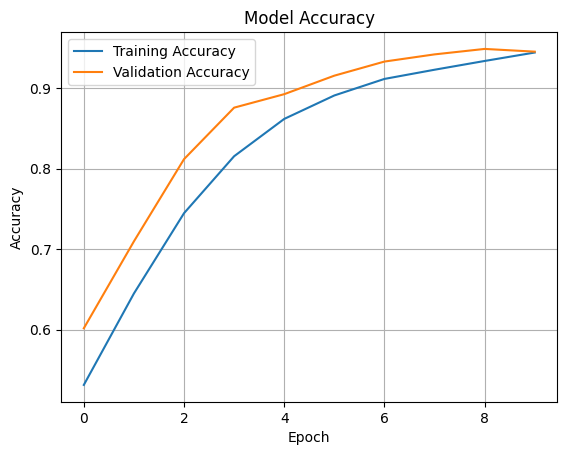

In [17]:
# visualizations of th training data
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.grid(True)
plt.show()

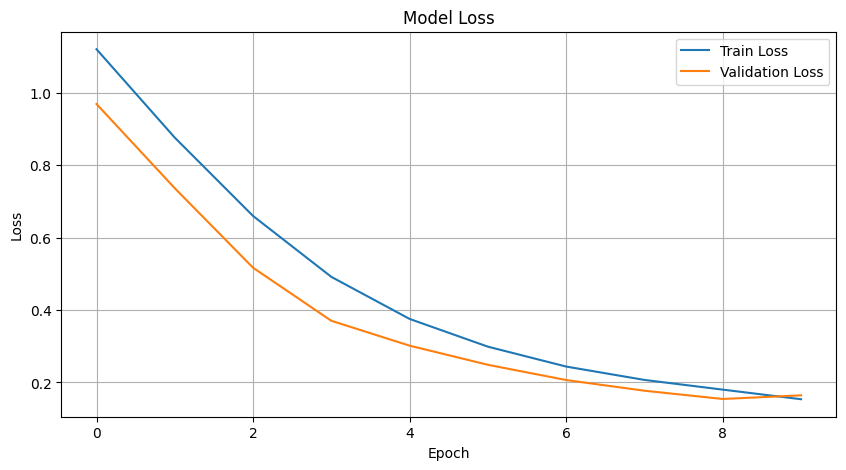

In [18]:
# Loss plot
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()